
# Forum des métiers - Répartition de groupes et allocation de slots

Ce notebook permet d'effectuer des allocations individuelles à des slots de visite de représentants des métiers

Contraintes :

- pas d'élève sans affectation de métier pour un créneau (timeslot) donné,
- le moins possible de métier (job) sans affectation de groupe pour un timeslot donné,
- nombre de souhaits par élève =< timeslots,
- il peut y avoir n représentants pour un métier donné.

Le choix d'affectation utilisé donne la priorité au remplissage de tous les slots des intervenants de manière équilibrée.

La note globale de satisfaction du choix des élèves est un peu plus élevée que sur une stratégie d'affectation selon les préférences élèves pures et le taux d'intervenants sans élève est le plus faible.

La conversion du contenu d'un fichier Excel au formal JSON peut être effectuée sur le site suivant :
https://tableconvert.com/excel-to-json

## Importations des modules

In [1]:
import pandas as pd

In [2]:
from modules.typedef import *
from modules.q_utils_2 import *
from modules.student_utils_2 import get_most_interested_student_for_job, get_copy_students, convert_to_student_timetable
from modules.timetable_utils_2 import timetable_student_view, get_timetable_intervenants
from modules.evaluation_2 import get_evaluation
from modules.sql_utils_2 import get_sql_student_data, get_sql_intervenants

# Structure des données

Le forum des métiers est une succession de sessions de rencontres entre des groupes d'élèves et des représentants de métiers.

Une session de rencontres entre élèves et représentants de métiers est dénommée comme étant un `timeslot` dans ce notebook.
Le forum des métiers est donc une succession de `timeslots`. Le nombre de `timeslots` est représenté par `NB_SLOTS`.

Pour une session de rencontre (un `timeslot`), chaque repésentant peut accueillir un nombre limité d'élèves. Cette limite est dénommée `batch_size`. Le groupe d'élèves accueillis pour un timeslot donné est dénommé `Q`.

Un timeslot est donc une liste des intervenants de métiers pour lesquels la file d'attente 'Q' est renseignée avec les identifiants des élèves qui visiteront cet intervenant pour ce timeslot.

Timeslot :

```Python
[ { 'id' : int , 'batch_size' : int, 'Q' : [ int ] } ]
```

Une `timetable` regroupe l'ensemble des `timeslots` du forum des métiers par ordre de sessions de rencontres.

Timetable :

```Python
[ Timeslot ]
```

## Fonctions d'allocation des élèves (itv-driven)

Pour chaque intervenant considéré tour à tour (et dont le métier ne figure pas dans la liste des métiers à ne plus considérer), par ordre d'intervenant dont le taux de remplissage de Q va du plus faible au plus important, on cherche à déterminer un élève ayant un choix (de rang de préférence le plus élevé) correspondant à la catégorie de métier représenté par cet intervenant. 

Cet élève ne doit pas avoir visité cet intervenant auparavant.

Si un élève est trouvé, on retire l'élève de la liste des candidats et on ajoute cet élève à la Q de l'intervenant.

Si aucun élève n'est trouvé, on ajoute le métier représenté par l'intervenant à la liste des métiers à ne plus considérer (blacklist).

In [3]:
def q_students_itv_driven_pass1(n_slot:int, q_intervenants:Q_Intervenants, students:list[Student])->Tuple[Q_Intervenants, list[Student], list[Student]]:
    NB_LOOP_MAX = 1000

    result_students = get_copy_students(students)
    remaining_students = result_students
    
    no_more_Q = False
    blacklisted_jobs=[]
    nb_loops = 0

    while((len(remaining_students)>0) and (not no_more_Q)):

        assert(nb_loops < NB_LOOP_MAX)
        nb_loops += 1

        # liste des intervenants ayant une file de visite Q qui n'est pas encore remplie et
        # classée du taux de remplissage de Q le plus faible vers le plus élevé.
        
        l_job_itv = [ job_itv for job_itv in get_next_q_to_load_sorted(q_intervenants) ]

        # list [(job, intervenant)] pour les jobs qui ne sont pas blacklisté i.e
        # pour les jobs pour lesquels il existe encore des élèves qui souhaitent visiter ce job
        l_job_itv_no_blacklisted = [ (job,itv) for (job,itv) in l_job_itv if not job in blacklisted_jobs ]

        if (len(l_job_itv_no_blacklisted)==0):
            # Il n'y a plus de job a traiter. Soit toutes les Q d'intervenants sont remplies soit 
            # tous les jobs sont maintenant blacklistés (i.e. aucun élève trouvé ayant un souhait pour tous ces 
            # métiers)

            # exit while loop
            no_more_Q = True
        else:

            # le job avec l'intervenant ayant sa file d'attente la moins remplie
            # est en tête de liste avec :
            # head is (job,itv), tail is *_ unused
            (job, itv), *_ = l_job_itv_no_blacklisted
            
            # chercher l'élève qui a émis le souhait de rang le plus élevé pour 
            # le job identifié comme ayant un intervenant avec la file d'attente la moins
            # remplie
            #     
            most_interested_student = get_most_interested_student_for_job(remaining_students,job)
            if most_interested_student != None:

                # ajouter (job, itv) dans la liste des itv_visited (slots) de l'élève 
                most_interested_student['itv_visited'].append((n_slot, (job,itv)))

                # ajouter l'élève dans la Q de l'intervenant pour le job
                q_intervenants[job][itv]['Q'].append(most_interested_student['id'])

                # remove the most interested student from remaining students
                remaining_students = [ s for s in remaining_students if s['id'] != most_interested_student['id']]
            else:
                # aucun élève intéressé par le job en pass1, ajouter le job en blacklist
                blacklisted_jobs.append(job)

    print(f'pass 1 : {nb_loops} loops')
    return q_intervenants, result_students, remaining_students

In [4]:
def q_students_itv_driven_pass2(n_slot:int, q_intervenants:Q_Intervenants, students:list[Student], remaining_students:list[Student])->Tuple[Q_Intervenants, list[Student]]:
    result_students = get_copy_students(students)

    for student in remaining_students:
        
        # liste des intervenants ayant une file de visite Q qui n'est pas encore remplie et
        # classée du taux de remplissage de Q le plus faible vers le plus élevé.

        l_q_job_itv = [ job_itv for job_itv in get_next_q_to_load_sorted(q_intervenants) ]

        job_yet_visited = { j for (s,(j,_)) in student['itv_visited'] }
        job_itv_yet_visited = { (j,i) for (s,(j,i)) in student['itv_visited'] }

        # liste des (job, itv) pour lesquels job n'a pas encore été visité par l'élève
        next_q_job_itv_1 = [ (j,i) for (j,i) in l_q_job_itv if not j in job_yet_visited ]

        # liste des (job, itv) pour lesquels (job,itv) n'a pas encore été visité
        next_q_job_itv_2 = [ (j,i) for (j,i) in l_q_job_itv if not (j,i) in job_itv_yet_visited ]

        job, itv = None, None

        if (len(next_q_job_itv_1)==0):
            if (len(next_q_job_itv_2)==0):
                print("(!) free student")
            else:
                # solution par défaut: on refait visiter un même job mais pas le même intervenant
                job, itv = next_q_job_itv_2[0]
        else:
            # solution préférentielle : on fait visiter un nouveau job
            job, itv = next_q_job_itv_1[0]

        if job != None:
            r_student = [ s for s in result_students if s['id'] == student['id'] ][0]
            r_student['itv_visited'].append((n_slot, (job, itv)))
            
            q_intervenants[job][itv]['Q'].append(student['id'])


    return q_intervenants, result_students



In [5]:
def get_timetable_itv_driven(nb_slots:int, students:list[Student], intervenants_data:Q_Intervenants)->Tuple[Timetable, list[Student]]:
    timetable = []
    for n_slot in range(nb_slots):
        
        print(f'processing slot : {n_slot}')

        q_intervenants = empty_q_intervenants(intervenants_data)

        q_intervenants, students, remaining_students = q_students_itv_driven_pass1(n_slot, q_intervenants, students)
        q_intervenants, students = q_students_itv_driven_pass2(n_slot, q_intervenants, students, remaining_students)
        timetable.append(q_intervenants)
    return timetable, students

## Application aux données réelles
### Intervenants driven
#### SQL

In [6]:
import sqlite3
from enum import Enum

In [7]:

con = sqlite3.connect("./data/2026/db-forum-notebook-20-itv-driven-2026-test.db")

In [8]:
# get students data

student_data = get_sql_student_data(con)
print("nb élèves : {}".format(len(student_data)))
print(pd.DataFrame(student_data)[0:5])

nb élèves : 210
     id               wishes itv_visited
0  3100   [10, 15, 2, 13, 5]          []
1  3101  [12, 15, 19, 7, 11]          []
2  3102   [11, 12, 9, 6, 16]          []
3  3103    [9, 10, 6, 18, 5]          []
4  3104    [9, 10, 17, 2, 8]          []


In [9]:
# intervenants data from SQL

intervenants_data_from_sql = get_sql_intervenants(con)
intervenants_data_from_sql[:]

[[],
 [{'id': 1, 'batch_size': 5, 'id_metier': '1-0', 'Q': []},
  {'id': 2, 'batch_size': 5, 'id_metier': '1-1', 'Q': []},
  {'id': 3, 'batch_size': 5, 'id_metier': '1-2', 'Q': []}],
 [{'id': 4, 'batch_size': 5, 'id_metier': '2-0', 'Q': []},
  {'id': 5, 'batch_size': 5, 'id_metier': '2-1', 'Q': []}],
 [{'id': 6, 'batch_size': 5, 'id_metier': '3-0', 'Q': []}],
 [{'id': 7, 'batch_size': 5, 'id_metier': '4-0', 'Q': []}],
 [{'id': 8, 'batch_size': 5, 'id_metier': '5-0', 'Q': []},
  {'id': 9, 'batch_size': 5, 'id_metier': '5-1', 'Q': []},
  {'id': 87, 'batch_size': 5, 'id_metier': '5-2', 'Q': []}],
 [{'id': 10, 'batch_size': 5, 'id_metier': '6-0', 'Q': []},
  {'id': 88, 'batch_size': 5, 'id_metier': '6-1', 'Q': []},
  {'id': 89, 'batch_size': 5, 'id_metier': '6-2', 'Q': []},
  {'id': 91, 'batch_size': 5, 'id_metier': '6-3', 'Q': []}],
 [{'id': 11, 'batch_size': 5, 'id_metier': '7-0', 'Q': []}],
 [{'id': 12, 'batch_size': 5, 'id_metier': '8-0', 'Q': []},
  {'id': 13, 'batch_size': 5, 'id_met

In [10]:
NB_SLOTS = 6

timetable, student_data = get_timetable_itv_driven(NB_SLOTS, student_data, intervenants_data_from_sql)
timetable = convert_to_student_timetable(NB_SLOTS, student_data)
q_intervenants = empty_q_intervenants(intervenants_data_from_sql)


processing slot : 0
pass 1 : 227 loops
processing slot : 1
pass 1 : 226 loops
processing slot : 2
pass 1 : 210 loops
processing slot : 3
pass 1 : 181 loops
processing slot : 4
pass 1 : 113 loops
processing slot : 5
pass 1 : 55 loops


In [11]:
# Affichage du nombre d'élèves par slot (en ligne) et par intervenant (en colonne)

pd.set_option("display.max_columns", 65)
pd.set_option("display.max_rows", 6)
df = pd.DataFrame(get_timetable_intervenants(timetable, q_intervenants))
df.sort_index(axis=1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,87,88,89,90,91
0,5,5,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,3,3,3,4,4,4,4,4,4,4,4,6,4,4,4,5,5,5,4,4,4,4,4,4,4,4,4
1,5,4,4,4,4,4,4,3,3,4,4,4,4,4,4,4,4,4,4,5,4,4,3,4,5,3,3,3,3,4,4,4,5,5,5,4,6,4,5,4,5,4,4,4,4,4,4,3,4,4,4,4
2,5,5,5,5,5,5,5,3,3,5,5,4,4,4,4,4,4,5,5,5,4,4,3,4,5,3,3,3,3,3,3,3,3,3,3,5,5,3,5,4,5,5,5,3,3,3,3,3,5,5,4,4
3,5,5,5,5,5,5,5,3,3,5,5,5,4,5,4,5,5,5,5,5,4,3,3,3,5,3,3,3,3,3,3,3,3,3,3,5,5,3,5,3,3,3,5,3,3,3,4,3,5,5,5,5
4,5,5,5,5,5,5,5,3,4,4,5,4,4,4,4,3,4,4,4,4,4,4,3,4,5,4,4,4,4,4,3,4,4,4,4,5,5,3,5,4,3,3,5,3,3,4,4,3,4,4,3,4
5,4,4,4,4,3,5,5,3,4,4,5,4,3,4,4,4,4,4,4,4,4,4,3,4,5,4,3,3,4,4,4,4,4,4,4,5,5,4,5,4,4,4,5,4,4,4,4,4,4,4,4,4


In [12]:
# timetable (student view)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 240)
timetable_students_sql = pd.DataFrame(timetable_student_view(timetable)).T
timetable_students_sql[0:5]

,0,1,2,3,4,5
3100,10-0,15-1,2-1,13-2,5-0,12-0
3101,12-6,15-0,19-3,10-3,13-2,11-0
3102,11-0,12-5,9-0,6-0,10-0,19-2
3103,9-4,10-0,6-2,5-0,19-3,18-0
3104,9-3,10-2,17-1,8-2,2-1,12-1


overall_student_satisfaction : 0.898
nb moyen d'élève par intervenant durant le forum : 24.2
deviation standard correspondante : 3.2
total nb élèves pour un intervenant - valeur max : 32
total nb élèves pour un intervenant - valeur min : 18
taille moyenne de batch d'élèves par slot : 4
nb intervenants sans visites pendant un slot : 0


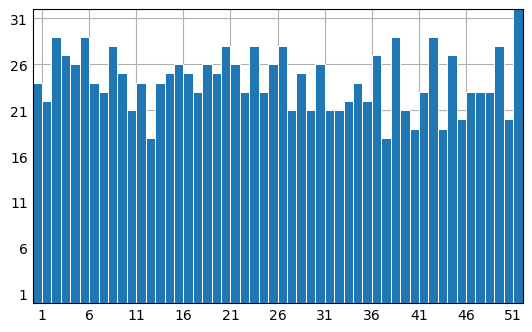

In [13]:
# évaluation de la timetable générée

get_evaluation(timetable, student_data, q_intervenants)

In [14]:
timetable_students_sql.to_csv('output_timetable_students_itv_driven_2026_from_sql_2.csv', sep=';', header=False)